Today let's look into some pretty neat SymPy functionality. I was in a fluid dynamics lecture, practicing taking notes with LaTeX on the go and stumbled upon this monstrosity:

$$ \Delta(k) = \frac{\rho_1-\rho_2}{\rho_1 + \rho_2} gk + \frac{\gamma k^3}{\rho_1 + \rho_2} - \frac{\rho_1 \rho_2}{(\rho_1 + \rho_2)^2} U^2 k^2 $$

(bonus points for whoever recognizes this!)

We were supposed to draw this for a few example sets of values. All right! I opened up `pinta` and scribbled a few squiggly lines with my small touchpad, following the blackboard drawings. It looked darn ugly, but that got me thinking. *`SymPy` has parsers, right? Can't I just parse that LaTeX equation into Python and make that plot pretty with matplotlib?*

Well, as it turns out, sure...

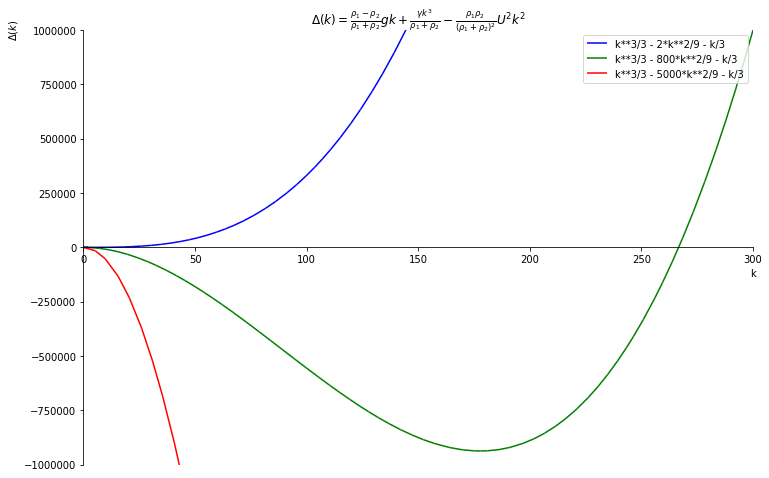

In [17]:
the_plot.show()

But it takes some tinkering.

<!-- TEASER_END -->
All right, let the tinkering commence! Let's get straight to the point. For this to run, you'll [need antlr4](https://docs.sympy.org/latest/modules/parsing.html#runtime-installation) (in current Jupyter, you can simply do `%conda install antlr-python-runtime` from within the Notebook).

We're going to simply dump the LaTeX string into `sympy.parsing.latex.parse_latex`, with the important caveat - this needs to be a `r"raw string"`. Otherwise, LaTeX is going to go wild put a carriage return into every `\rho`.

In [2]:
import sympy
from sympy.parsing.latex import parse_latex
latex_string = r"\Delta(k) = \frac{\rho_1-\rho_2}{\rho_1 + \rho_2} gk + \frac{\gamma k^3}{\rho_1 + \rho_2} - \frac{\rho_1 \rho_2}{(\rho_1 + \rho_2)^2} U^2 k^2"
equation = parse_latex(latex_string)
equation

Eq(Delta(k), -U**2*k**2*rho_{1}*rho_{2}/(rho_{1} + rho_{2})**2 + (g*k)*((rho_{1} - rho_{2})/(rho_{1} + rho_{2})) + (gamma*k**3)/(rho_{1} + rho_{2}))

We can access the variables we'd like to substitute (as SymPy symbols) using `equation.free_symbols`:

In [3]:
equation.free_symbols

{U, g, gamma, k, rho_{1}, rho_{2}}

Ideally what I'd like to do is use `.subs` on the `equation` to plug in numerical values. To achieve this, it would *probably* be easiest to turn the symbols into Python variables. However...

In [7]:
U, g, gamma, k, rho_1, rho_2 = equation.free_symbols
U, gamma, rho_1

(g, U, gamma)

... the unordered nature of Python's `set` comes back with a vengeance! It's [not too trivial to get these out in the right order](https://stackoverflow.com/questions/6405512/get-a-list-from-a-set-in-python). You could try `sorted`, but one does not simply compare `Symbol`s:

In [8]:
sorted(equation.free_symbols)

TypeError: cannot determine truth value of Relational

What I ended up doing here is:

In [9]:
U, g, gamma, k, rho_1, rho_2 = sorted(equation.free_symbols,
                                      key = lambda x: str(x)   # the literal key part here - just sort them alphabetically!
                                     )
U, g, gamma, k, rho_1, rho_2

(U, g, gamma, k, rho_{1}, rho_{2})

And now we can simply use `subs` with a dictionary:

In [10]:
equation.subs(dict(rho_1=1,
                   rho_2=2,
                   gamma=1,
                   g=1,
                  )
             )

Eq(Delta(k), -U**2*k**2*rho_{1}*rho_{2}/(rho_{1} + rho_{2})**2 + k**3/(rho_{1} + rho_{2}) + k*(rho_{1} - rho_{2})/(rho_{1} + rho_{2}))

... or can we? This does not work on `rho_{1}` and `rho_{2}`. Here's why:

In [11]:
dict(rho_1=1,
     rho_2=2,
     gamma=1,
     g=1,
)

{'rho_1': 1, 'rho_2': 2, 'gamma': 1, 'g': 1}

Well duh, those are string values when input this way, and `"rho_1" != "rho_{1}"`!

We could instead do the following:

In [12]:
better_dict = {rho_1: 1,
 rho_2: 2,
 gamma: 1,
 g: 1,
}
better_dict

{rho_{1}: 1, rho_{2}: 2, gamma: 1, g: 1}

Will that work?

In [13]:
equation.subs(better_dict)

Eq(Delta(k), -2*U**2*k**2/9 + k**3/3 - k/3)

Finally! However, along the way you may have noticed a simpler way to do this:

In [14]:
simpler_equation = equation.subs({
     "rho_{1}": 1,
     "rho_{2}": 2,
     "gamma": 1,
     "g": 1,
})
simpler_equation

Eq(Delta(k), -2*U**2*k**2/9 + k**3/3 - k/3)

Note how this did not need us to even touch `equation.free_symbols` or mess around with `sorted` at all! I'm leaving the exploratory part here though - it might help someone looking to access variables in a `parse_latex` expression.

We may now plot it:

In [15]:
DeltaK = simpler_equation.rhs
DeltaK

-2*U**2*k**2/9 + k**3/3 - k/3

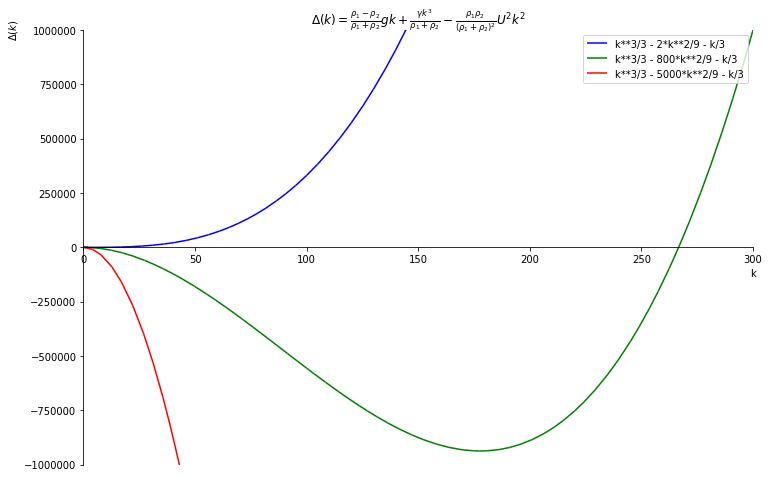

In [16]:
import sympy.plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8
k_range = (k, 0, 300)
colors = ["blue", "green", "red"]
U_values = [1, 20, 50]
plots = []
for u, color in zip(U_values, colors):
    plot = sympy.plot(DeltaK.subs(U, u), k_range,
                      show=False,
                     line_color=color,
                     legend=True,
                     ylabel=r"$\Delta(k)$",
                     ylim = (-1e6, 1e6),
                     xlim = (0, 300),
                     title = f"${latex_string}$",
                     )
    plots.append(plot)

plots[0].extend(plots[1])
plots[0].extend(plots[2])
the_plot = plots[0]
the_plot.show()

And, while not beautiful, it's much more pretty than what I got together with `pinta`!